In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

from setup.univ_setup import *
from setup.utils import *
from factor_mining.combine_factors import *
from factor_mining.factor_preprocessing import *
from performance_analysis.pa_core import *

from backtest.BackTest import *
from backtest.regression_portfolio import *
from backtest.simple_optim import SimpleOptimizer

from factor_mining.Mark0 import * # This is alpha file

In [2]:
%%time
### universe setup ###
datadir = '/home/derek-qi/Documents/R3000_Data/data/r3000/'
univ = univ_setup(datadir, version=5, wFund=True)
filt_na(univ)

Setup R3000 universe
use existing binary file
CPU times: user 2.66 s, sys: 212 ms, total: 2.87 s
Wall time: 2.87 s


In [3]:
%%time
### model configuration ###
print('Calculate factors')
# define and calculate all factors
factors = alpha_wFund_00(univ)

factor_names = list(factors.keys())
factors_dict = factors
factor_names = [k for k in factors_dict.keys()]
N_f = len(factor_names)
datelst = sorted(factors_dict[factor_names[0]].keys())

# concat into factor exposure matrices
factor_exp_mat = combine_factors(factors)
filt_na(factor_exp_mat)

Calculate factors
CPU times: user 53.4 s, sys: 764 ms, total: 54.1 s
Wall time: 54.1 s


In [4]:
### Filt the universe ###
print('Filt the untradables')

filt_byval(univ, 'in_r3000', 0)
filt_byval(univ, 'price', 10)
# filt_byval(univ, 'not_in_MA', 0)
filt_byval(univ, 'volume', 300000)
filt_byval(univ, 'div_ratio', 10, keep='below')

factor_exp_mat = merge(factor_exp_mat, univ, right_cols=['f_log_ret_1'])
print('Done')

# Preprocessing factor expsure matrices
print('Standard scale each factor')
factor_exp_mat = process_batch(factor_exp_mat, standardize, factor_names=factor_names)
print('Winsorize with +/- 3 std')
factor_exp_mat = process_batch(factor_exp_mat, winsorize_std, factor_names=factor_names)
print('Done')

Filt the untradables
Done
Standard scale each factor
Winsorize with +/- 3 std
Done


In [30]:
%%time
soptim = SimpleOptimizer(n=10)
start_date = np.datetime64('2013-01-01')
end_date = np.datetime64('2016-12-31')

factor_names = list(factors.keys())
spcalc = RegressionPtflSpcalc(all_factor_names=factor_names, optimzr=soptim, smoothing='simple')
bt = BackTest(univ=univ, factor_exp_mat=factor_exp_mat, daterange=[start_date, end_date], sp_calc=spcalc, rebal=1)
ptfl_lst, pnl_lst = bt.calc_pnl(silence=False, has_short=True, n_lookback=104)

CPU times: user 12.8 s, sys: 212 ms, total: 13.1 s
Wall time: 6.55 s


In [31]:
bt.calc_pa(silent=False)

CAGR :	 0.496721173581
Volatility :	 0.40712865257
Sharpe :	 0.990539056268
Max_Drawdown :	 0.497204563195
Drawdown_Length :	 2


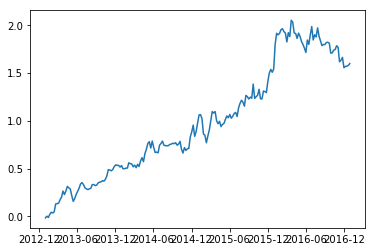

In [32]:
dlst = sorted(univ.keys())
dlst = [d for d in dlst if d >= start_date and d <= end_date]
plt.plot(dlst, np.cumsum(pnl_lst['pnl']))
plt.show()

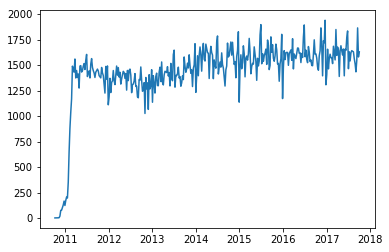

In [42]:
n_ins = get_count(univ)
plt.plot(n_ins['date'], n_ins['count'])
plt.show()